<a href="https://colab.research.google.com/github/malcolmlett/ml-learning/blob/main/Learning_visualisations_v15_gradientNorms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Visualisations v15: Gradient Norms
Firstly, my latest literature survey has found that it's very common to use the frobenius norm of gradient tensors to measure their magnitude. Secondly, I've since realised that when collecting stats per-epoch, I need to compute the _mean_ or _sum_ of gradients over the entire epoch, rather than blindly picking the latest value.

Together, that could produce far smoother and more meaningful results when plotting 1) per-epoch stats, 2) model-wide stats of magnitudes (per-epoch or per-step), and 3) comparing layer magnitudes.

In [128]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git fetch
else:
  !git clone https://github.com/malcolmlett/ml-learning.git repo

# lock to revision
!cd repo && git checkout 60c9f44
#!cd repo && git pull

import sys
sys.path.append('repo')

import train_observability_toolkit as tot
from importlib import reload
reload(tot)

HEAD is now at 8a9c32e Use norms in main plot_value_history()
remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0 (from 0)
Unpacking objects: 100% (3/3), 290 bytes | 41.00 KiB/s, done.
From https://github.com/malcolmlett/ml-learning
   8a9c32e..3d37b67  main       -> origin/main
Updating 8a9c32e..3d37b67
Fast-forward
 train_observability_toolkit.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


<module 'train_observability_toolkit' from '/content/repo/train_observability_toolkit.py'>

In [2]:
import train_observability_toolkit_test
reload(train_observability_toolkit_test)
reload(tot)
train_observability_toolkit_test.run_test_suite()

All train_observability_toolkit tests passed.


In [3]:
import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers, models, datasets, optimizers, metrics
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
import sklearn.datasets
import time
import timeit
import tqdm

## Basics


In [4]:
def binary_classification_dataset():
  np.random.seed(1)
  train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
  np.random.seed(2)
  test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
  train_X = train_X
  train_Y = train_Y.reshape((-1, 1))
  test_X = test_X
  test_Y = test_Y.reshape((-1, 1))
  return train_X, train_Y, test_X, test_Y

def mnist_dataset():
  np.random.seed(1)
  (x_train, y_train), _ = tf.keras.datasets.mnist.load_data()
  # Normalize the data
  x_train = x_train / 255.0
  return x_train, y_train

def binary_classification_model(init_scheme):
  """
  init_scheme: one of "zeros", "large_normal", "he_normal"
  """
  if init_scheme == "zeros":
    kernel_initializer='zeros'
  elif init_scheme == "large_normal":
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=10.)
  elif init_scheme == "he_normal":
    kernel_initializer='he_normal'
  else:
    raise ValueError("Unknown init_scheme")

  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(5, activation='relu', kernel_initializer=kernel_initializer),
    tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=kernel_initializer)
  ])

  return model

def mnist_cnn_model():
  model = tf.keras.Sequential([
    layers.Input(shape=(28, 28)),
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', strides=2, activation='relu'),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  return model

class TimingCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self._start = None
    self._epochs = None
    self.total = None
    self.per_epoch = None

  def on_epoch_begin(self, epoch, logs=None):
    if epoch == 1:
      self._start = tf.timestamp()
    self._epochs = epoch-1

  def on_train_end(self, logs=None):
    self.total = (tf.timestamp() - self._start).numpy()
    self.per_epoch = self.total / (self._epochs)

# Basic implementation
First, we'll start with a basic data collection routine to confirm how we can most efficiently aggregate sum or mean values over the course of an epoch.

train_X: (300, 2), train_Y: (300, 1), test_X: (100, 2), test_Y: (100, 1)


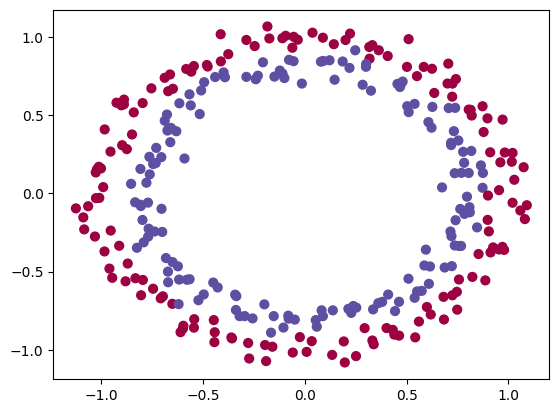

In [ ]:
train_X, train_Y, test_X, test_Y = binary_classification_dataset()
print(f"train_X: {train_X.shape}, train_Y: {train_Y.shape}, test_X: {test_X.shape}, test_Y: {test_Y.shape}")

plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
plt.show()

In [ ]:
# Timings CPU - on binary classification model:
#  - 45ms - baseline
#  - 65ms - naive accumulator = accumalotor + value, with minimal pre-initialisation, no @tf.function
#  - 65ms - naive accumulator = accumalotor + value, with minimal pre-initialisation, with @tf.function
#  - 77ms - tf.Variable accumulator with pre-initialisation, no @tf.function
#  - 77ms - tf.Variable accumulator with pre-initialisation, with @tf.function
# Timings GPU - on MNIST classification model (32000 samples, batch-size 64):
#  - 3700ms (5.5ms/step) - baseline
#  - 4700ms (7.0ms/step) - naive accumulator = accumalotor + value, with minimal pre-initialisation, without @tf.function
#  - 5400ms (6.8ms/step) - naive accumulator = accumalotor + value, with minimal pre-initialisation, with @tf.function
#  - 5400ms (7.2ms/step) - tf.Variable accumulator with pre-initialisation, without @tf.function
#  - 3770ms (6.5ms/step) - tf.Variable accumulator with pre-initialisation, with @tf.function
#  - note: the supplied gradients are GPU-bound. So are the TF value and tf.Variable() accumulators.
class MyCallback1(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._accumulators = None
    self._norms = []  # list (by iteration) of list (by variable) of scalar norms of gradients

  @property
  def norms(self):
    return np.stack(self._norms, axis=0)

  def on_epoch_begin(self, epoch):
    if self._accumulators is not None:
      self._accumulators = [None] * len(self._accumulators)

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    self._norms.append([tf.norm(tensor)/tf.sqrt(tf.cast(tf.size(tensor), dtype=tensor.dtype)) if tensor is not None else None for tensor in self._accumulators])

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    self._init_accumulators(gradients)
    self._accumulators = self._accumulate(self._accumulators, gradients)

  def _init_accumulators(self, gradients):
    if self._accumulators is None:
      self._accumulators = [None] * len(gradients)

  @tf.function
  def _accumulate(self, accumulators, values):
    res = []
    for accumulator, value in zip(accumulators, values):
      if value is not None:
        if accumulator is None:
          accumulator = value
        else:
          accumulator += value
      else:
        accumulator = None
      res.append(accumulator)
    return res

class MyCallback2(tot.BaseGradientCallback):
  def __init__(self):
    super().__init__()
    self._accumulators = None
    self._norms = []  # list (by iteration) of list (by variable) of scalar norms of gradients
    self._steps = None

  @property
  def norms(self):
    return np.stack(self._norms, axis=0)

  def on_epoch_begin(self, epoch):
    if self._accumulators is not None:
      for a in self._accumulators:
        a.assign(tf.zeros(a.shape))

  def on_epoch_end(self, epoch, loss, gradients, trainable_variables, activations, output_gradients):
    scale = tf.cast(self._steps, dtype=tf.float32)
    self._norms.append([tf.norm(tensor/scale)/tf.sqrt(tf.cast(tf.size(tensor), dtype=tensor.dtype)) if tensor is not None else None for tensor in self._accumulators])

  def on_train_batch_end(self, batch, loss, gradients, trainable_variables, activations, output_gradients):
    # init
    if self._accumulators is None:
      self._accumulators = [tf.Variable(tf.zeros_like(g), dtype=g.dtype) for g in gradients]

    # accumulate
    self._accumulate(self._accumulators, gradients)
    self._steps = batch

  @tf.function
  def _accumulate(self, accumulators, values):
    for accumulator, value in zip(accumulators, values):
      if value is not None:
        accumulator.assign_add(value)

reload(tot)
tf.config.run_functions_eagerly(False)

cb = MyCallback1()
timing = TimingCallback()
#model = binary_classification_model('he_normal')
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
#train_X, train_Y, _, _ = binary_classification_dataset()
#dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
model = mnist_cnn_model()
train_X, train_Y = mnist_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y)).take(32000).batch(64)
start = tf.timestamp()
#history = tot.fit(model, dataset.batch(32), epochs=100, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), tot.HistoryStats(), cb, timing])
history = tot.fit(model, dataset, epochs=10, callbacks=[tot.HistoryStats(), cb , timing])
duration = (tf.timestamp() - start).numpy()
print(f"Total training time: {duration:.2f} secs. Average: {timing.per_epoch*1000:.2f}ms/epoch")


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7970 - loss: 0.6822
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9658 - loss: 0.1115
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9790 - loss: 0.0710
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9844 - loss: 0.0514
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9900 - loss: 0.0338
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9918 - loss: 0.0252
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9934 - loss: 0.0198
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9949 - loss: 0.0163
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9956 - loss: 0.0134
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9966 - loss: 0.0105
Total training time: 43.79 secs. Average: 4800.70ms/epoch


In [ ]:
cb.norms.shape

(10, 10)

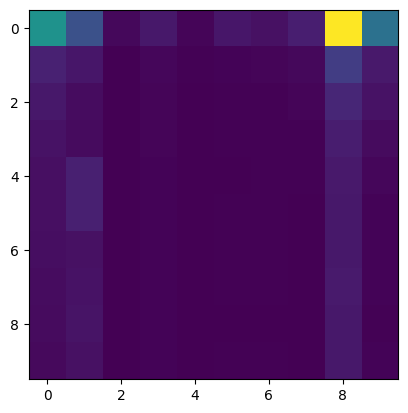

In [ ]:
plt.imshow(cb.norms)

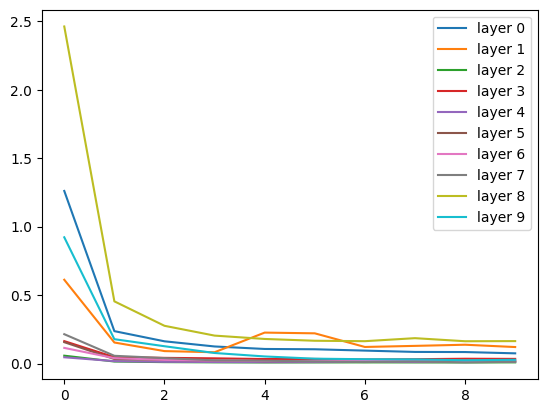

In [ ]:
for c in range(cb.norms.shape[1]):
  plt.plot(cb.norms[:,c], label=f"layer {c}")
plt.legend()
#plt.yscale('log')
plt.show()

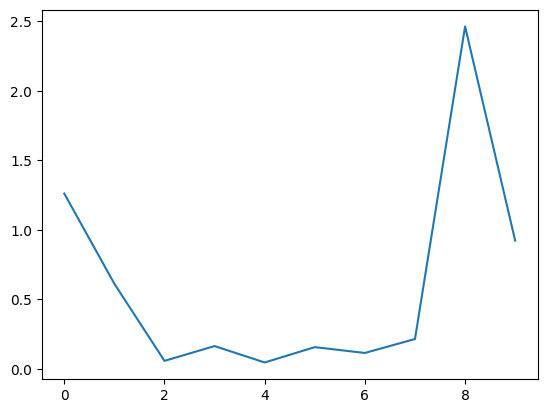

In [ ]:
plt.plot(cb.norms[0,:])

In [ ]:
a = tf.zeros((500,100))
a.device

'/job:localhost/replica:0/task:0/device:GPU:0'

In [ ]:
reload(tot)
tot.reload_safe_check(tot.GradientHistoryCallback())

True

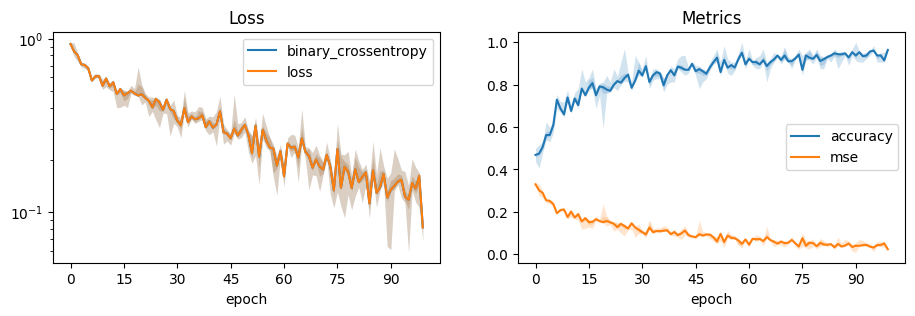

In [ ]:
tot.plot_train_history(history)

## Revised standard observability results
Now update the observability toolkit and run against the basic classification dataset to compare results.

Reference results:
* see: `Learning_visualisations_v13.ipynb` - "Learning Visualisations v13: Extending all callbacks for value stats, magnitude stats, and activity stats, plus a new HistoryStats callback"

In [112]:
reload(tot)
tf.config.run_functions_eagerly(False)

variables = tot.VariableHistoryCallback(per_step=True, collection_sets=[{}])
gradients = tot.GradientHistoryCallback(per_step=True, collection_sets=[{}])
outputs = tot.LayerOutputHistoryCallback(per_step=True, collection_sets=[{}])
epoch_gradients = tot.GradientHistoryCallback(per_step=False, collection_sets=[{}])
output_gradients = tot.LayerOutputGradientHistoryCallback(per_step=True, collection_sets=[{}])

model = binary_classification_model('he_normal')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse', 'binary_crossentropy'])
train_X, train_Y, _, _ = binary_classification_dataset()
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_Y))
history = tot.fit(model, dataset.batch(32), epochs=10, verbose=0, callbacks=[tot.LessVerboseProgressLogger(), variables, gradients, epoch_gradients, outputs, output_gradients, tot.HistoryStats(per_step=True)])

Epoch     1 - 12.10s/epoch: accuracy: 0.5300  binary_crossentropy: 0.7150  loss: 0.7150  mse: 0.2584  
Epoch     2 - 2.49s/epoch: accuracy: 0.6067  binary_crossentropy: 0.6682  loss: 0.6682  mse: 0.2381  
Epoch     3 - 579.02ms/epoch: accuracy: 0.6333  binary_crossentropy: 0.6548  loss: 0.6548  mse: 0.2316  
Epoch     4 - 604.48ms/epoch: accuracy: 0.6800  binary_crossentropy: 0.6257  loss: 0.6257  mse: 0.2164  
Epoch     5 - 605.95ms/epoch: accuracy: 0.6467  binary_crossentropy: 0.6431  loss: 0.6431  mse: 0.2251  
Epoch     6 - 590.84ms/epoch: accuracy: 0.7100  binary_crossentropy: 0.5880  loss: 0.5880  mse: 0.2011  
Epoch     7 - 607.16ms/epoch: accuracy: 0.6633  binary_crossentropy: 0.6114  loss: 0.6114  mse: 0.2100  
Epoch     8 - 628.67ms/epoch: accuracy: 0.6733  binary_crossentropy: 0.5897  loss: 0.5897  mse: 0.2023  
Epoch     9 - 1.23s/epoch: accuracy: 0.7067  binary_crossentropy: 0.5584  loss: 0.5584  mse: 0.1899  
Epoch    10 - 578.90ms/epoch: accuracy: 0.7100  binary_crossent

In [99]:
# verify that per-epoch gradients are correctly summed over each step
batch_count = int(len(gradients.steps) / len(epoch_gradients.epochs))
print(f"epochs:      {len(epoch_gradients.epochs)}")
print(f"batch_count: {batch_count}")
print(f"variables:   {len(model.variables)}")
err_found = False
for epoch in range(len(epoch_gradients.epochs)):
  for v_idx in range(len(model.variables)):
    if model.variables[v_idx].trainable:
      it_start = epoch * batch_count
      it_end = (epoch+1) * batch_count
      batch_grads = np.stack(gradients.gradients[v_idx][it_start:it_end], axis=0)
      pred_epoch_grads = np.sum(batch_grads, axis=0)
      batch_grad_norm = tf.norm(pred_epoch_grads)

      epoch_grads = epoch_gradients.gradients[v_idx][epoch]
      epoch_norm = tf.norm(epoch_grads)

      if not np.allclose(pred_epoch_grads, epoch_grads):
        err_found = True
        err = np.sqrt(np.mean((pred_epoch_grads - epoch_grads)**2))
        print(f"  [epoch {epoch}, variable {v_idx}]: err: {err} <- batch_grads: {batch_grads.shape}, epoch_grads: {epoch_grads.shape}, norms: {batch_grad_norm} vs {epoch_norm}")
if not err_found:
  print(f"All epoch gradients match sum of per-step gradients")

epochs:      10
batch_count: 10
variables:   20
All epoch gradients match sum of per-step gradients


In [100]:
# verify that norms are what we'd expect if computing manually
batch_count = int(len(gradients.steps) / len(epoch_gradients.epochs))
print(f"epochs:      {len(epoch_gradients.epochs)}")
print(f"steps:       {len(gradients.steps)}")
print(f"variables:   {len(model.variables)}")

err_found = False
for step in range(len(gradients.steps)):
  for v_idx in range(len(model.variables)):
    if model.variables[v_idx].trainable:
      norm = gradients.value_norms[v_idx][step]
      raw_grads = gradients.gradients[v_idx][step]

      size = tf.cast(tf.size(raw_grads), dtype=raw_grads.dtype)
      raw_grad_norm = tf.norm(raw_grads) / tf.sqrt(size)

      if not np.allclose(norm, raw_grad_norm):
        err_found = True
        err = norm - raw_grad_norm
        print(f"  [step {step}, variable {v_idx}]: err: {err} <- raw grads: {raw_grads.shape}, raw grad norm: {raw_grad_norm}, collected norm: {norm}")
if not err_found:
  print(f"All per-step norms match expected values")

err_found = False
for epoch in range(len(epoch_gradients.epochs)):
  for v_idx in range(len(model.variables)):
    if model.variables[v_idx].trainable:
      norm = epoch_gradients.value_norms[v_idx][epoch]
      raw_grads = epoch_gradients.gradients[v_idx][epoch]

      size = tf.cast(tf.size(raw_grads), dtype=raw_grads.dtype)
      raw_grad_norm = tf.norm(raw_grads) / tf.sqrt(size)

      if not np.allclose(norm, raw_grad_norm):
        err_found = True
        err = norm - raw_grad_norm
        print(f"  [epoch {epoch}, variable {v_idx}]: err: {err} <- raw grads: {raw_grads.shape}, raw grad norm: {raw_grad_norm}, collected norm: {norm}")
if not err_found:
  print(f"All per-epoch norms match expected values")

epochs:      10
steps:       100
variables:   20
All per-step norms match expected values
All per-epoch norms match expected values


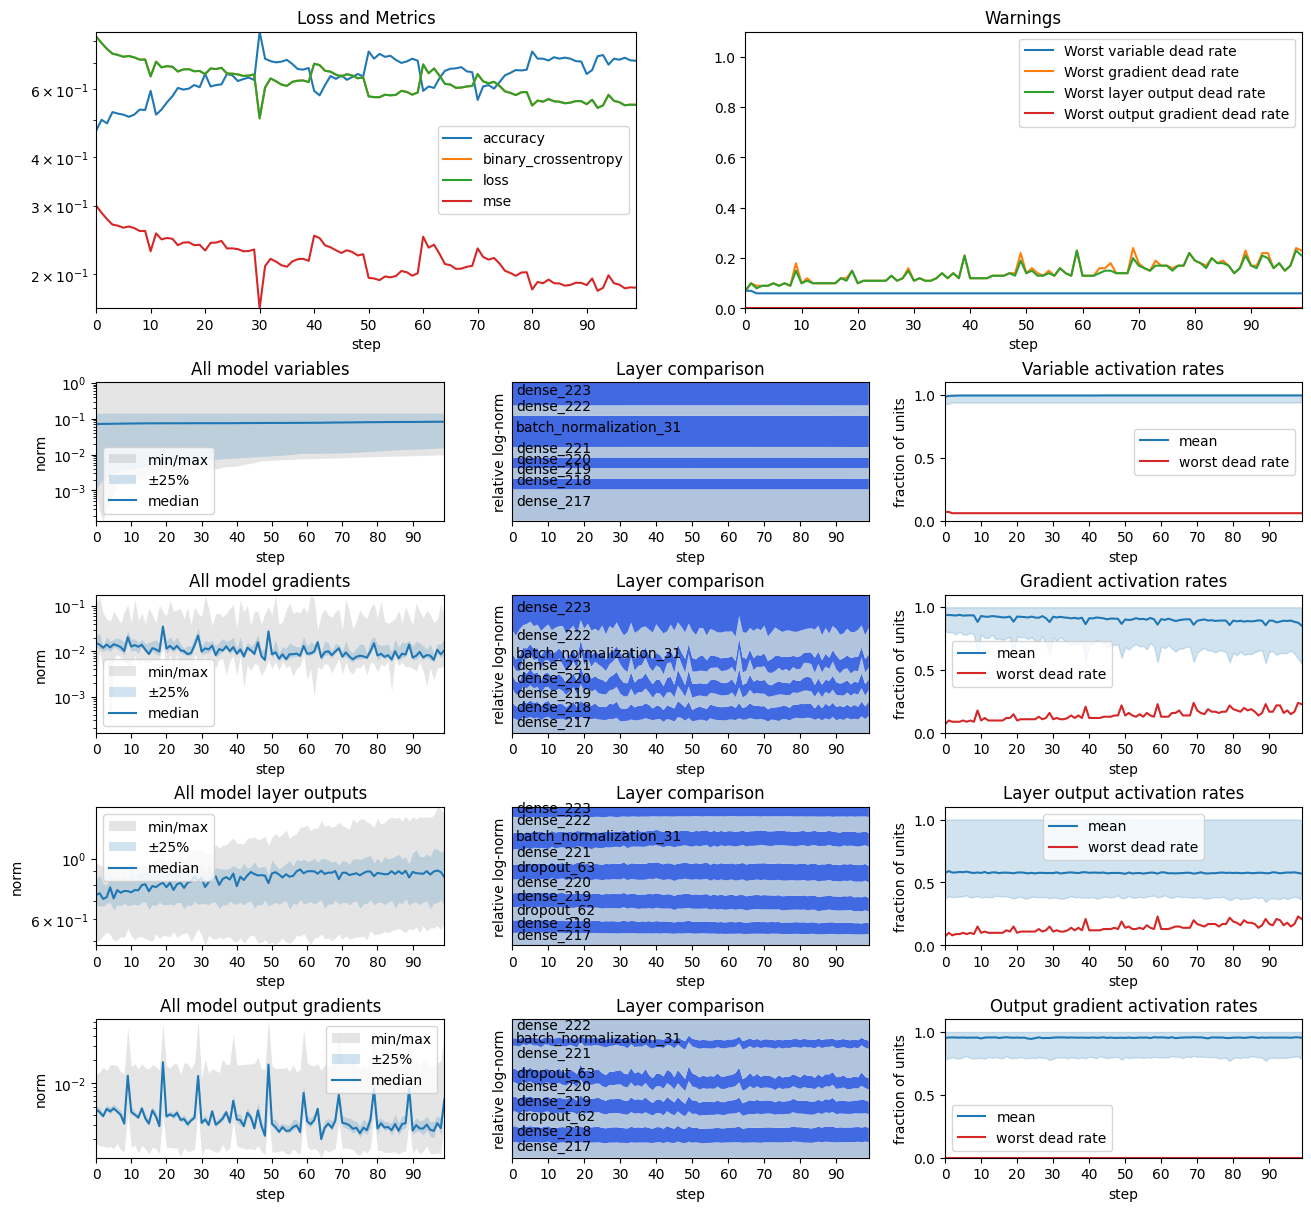

In [132]:
reload(tot)
tot.plot_history_overview(callbacks=[history, variables, gradients, outputs, output_gradients])

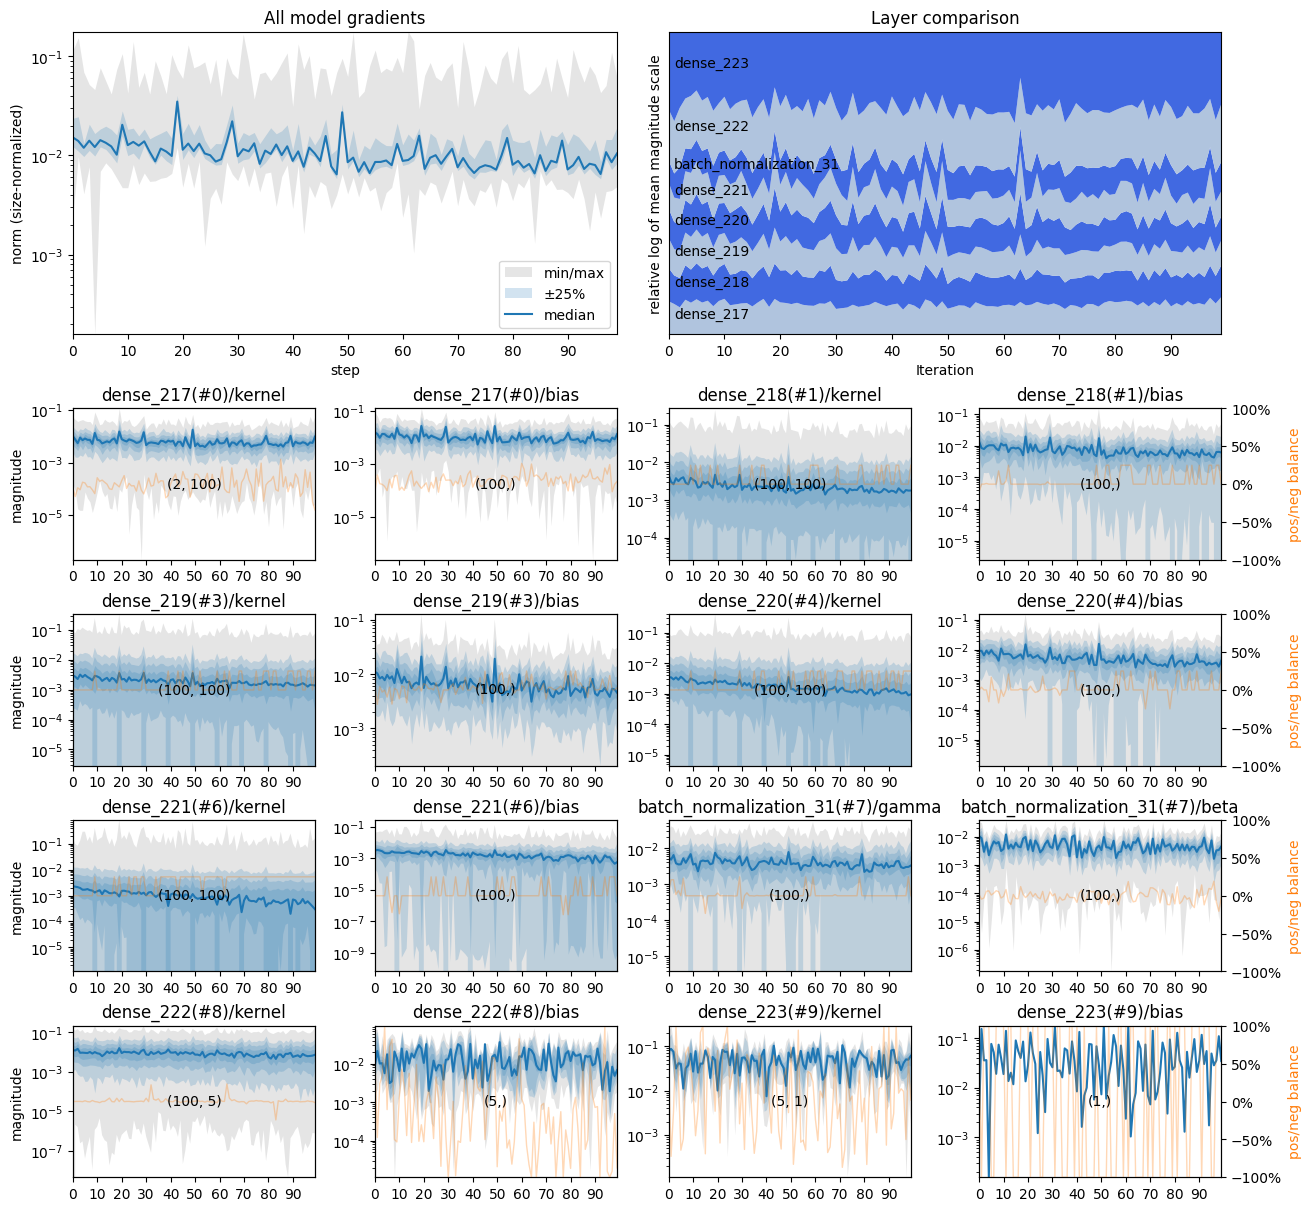

In [143]:
reload(tot)
tot.plot_value_history(gradients, show='magnitudes')

## Final thoughts
Using norms instead of estimated magnitude means didn't make much difference. Technically this the difference between L2-norms and L1-norms, with the added advantage of directly calculating the L2-norms instead of _estimating_ the L1-norms.

In practice, the difference turned out to be small. The layer comparisons plot is a little smoother - which is nice. And it's interesting that it kept some spikyness while losing others, suggesting that there are times when it goes spiky and we want to see those times.

In any case, having the norms is more consistent with what scientifit literature uses, so I'll be on better ground when writing about this.